In [4]:
# Mirar este -> https://colab.research.google.com/drive/1DQc8a-WOTctenvoy5T0lWUXn47EuteCy?usp=sharing#scrollTo=BtEYnFkNyN_s
import pandas as pd
from PIL import Image
import pandas as pd
import os

carpeta = 'spiral/training'

# Lista para almacenar las rutas de los archivos
rutas_archivos = []

# Obtener la lista de archivos en la carpeta
for root, dirs, files in os.walk(carpeta):
    for file in files:
        # Añadir la ruta completa del archivo a la lista
        ruta_completa = os.path.join(root, file)
        rutas_archivos.append(ruta_completa)

# Crear un DataFrame de ejemplo con rutas de imágenes
data = {'imagen': rutas_archivos}
df = pd.DataFrame(data)

# Función para obtener la carpeta de una ruta
def obtener_carpeta(ruta):
    return os.path.dirname(ruta)

# Función para obtener el nombre de la imagen sin la extensión
def obtener_nombre_imagen(ruta):
    return os.path.splitext(os.path.basename(ruta))[0]

# Agregar una columna 'carpeta' al DataFrame
df['carpeta'] = df['imagen'].apply(obtener_carpeta)

df['carpeta'] = df['carpeta'].map({'spiral/training\healthy': 0, 'spiral/training\parkinson': 1})
# Mostrar el DataFrame resultante
print(df)

                                   imagen  carpeta
0     spiral/training\healthy\V01HE02.png        0
1     spiral/training\healthy\V01HE03.png        0
2     spiral/training\healthy\V02HE02.png        0
3     spiral/training\healthy\V02HE03.png        0
4      spiral/training\healthy\V03HE2.png        0
..                                    ...      ...
67  spiral/training\parkinson\V13PE03.png        1
68  spiral/training\parkinson\V14PE01.png        1
69  spiral/training\parkinson\V14PE02.png        1
70  spiral/training\parkinson\V15PE02.png        1
71  spiral/training\parkinson\V15PE03.png        1

[72 rows x 2 columns]


In [5]:
X = df['imagen']
y = df['carpeta']

In [37]:
import os
from PIL import Image
import pandas as pd
import numpy as np

# Directorio principal que contiene la carpeta 'training'
directorio_principal = 'spirals/spiral/training'

# Lista para almacenar tuplas de la forma (bits_normalizados, etiqueta)
datos = []

# Función para convertir una imagen a bits
def image_to_bits(image):
    # Convertir la imagen a escala de grises y redimensionar a (100, 100)
    img_gray = image.convert('L').resize((100, 100))

    # Obtener los datos de píxeles como una matriz de numpy
    bits_numericos = np.array(img_gray, dtype=np.float32) / 255.0  # Normalizar los valores de píxeles

    return bits_numericos

# Crear un DataFrame con las rutas de las imágenes y sus etiquetas
rutas_imagenes = []
etiquetas = []

for root, dirs, files in os.walk(directorio_principal):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg"):
            ruta_imagen = os.path.join(root, file)
            etiqueta = 1 if "parkinson" in root else 0  # Asignar 1 a parkinson, 0 a healthy
            rutas_imagenes.append(ruta_imagen)
            etiquetas.append(etiqueta)

df = pd.DataFrame({'imagen': rutas_imagenes, 'etiqueta': etiquetas})

# Cargar imágenes y etiquetas
for _, row in df.iterrows():
    try:
        imagen = Image.open(row['imagen'])
        bits_numericos = image_to_bits(imagen)

        datos.append((bits_numericos, row['etiqueta']))
    except Exception as e:
        print(f"Error al abrir la imagen {row['imagen']}: {e}")

# Asegurarse de que todas las imágenes tengan la misma longitud máxima
max_length = max(len(bits) for bits, _ in datos)

# Inicializar X con ceros
X = np.zeros((len(datos), max_length, 100, 1), dtype=np.float32)

# Copiar los bits en X
for i, (bits, _) in enumerate(datos):
    np.copyto(X[i, :len(bits), :, 0], bits)

# Mostrar la forma de X
print(X.shape)


(72, 100, 100, 1)


In [38]:
X = np.array(X)
y = np.array(y)
X

array([[[[0.9490196 ],
         [0.9372549 ],
         [0.9372549 ],
         ...,
         [0.9098039 ],
         [0.9098039 ],
         [0.91764706]],

        [[0.9529412 ],
         [0.9411765 ],
         [0.92156863],
         ...,
         [0.9254902 ],
         [0.91764706],
         [0.90588236]],

        [[0.94509804],
         [0.9607843 ],
         [0.9411765 ],
         ...,
         [0.9372549 ],
         [0.9372549 ],
         [0.9254902 ]],

        ...,

        [[0.94509804],
         [0.92941177],
         [0.9372549 ],
         ...,
         [0.94509804],
         [0.92941177],
         [0.9254902 ]],

        [[0.92941177],
         [0.92156863],
         [0.92941177],
         ...,
         [0.92156863],
         [0.93333334],
         [0.9254902 ]],

        [[0.9411765 ],
         [0.9254902 ],
         [0.9372549 ],
         ...,
         [0.9372549 ],
         [0.90588236],
         [0.90588236]]],


       [[[0.9137255 ],
         [0.8980392 ],
         [0.91

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Asegurarse de que todas las secuencias tengan la misma longitud máxima
max_length = max(len(bits) for bits, _ in datos)

# Inicializar X con ceros
X = np.zeros((len(datos), max_length, 100, 1), dtype=np.float32)

# Copiar los bits en X
for i, (bits, _) in enumerate(datos):
    # Reshape bits a (100, 100, 1) antes de asignar
    bits_reshaped = bits.reshape((100, 100, 1))
    X[i, :len(bits_reshaped), :, :] = bits_reshaped

# Dividir los datos en conjuntos de entrenamiento y prueba
y = np.array([etiqueta for _, etiqueta in datos])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(max_length, 100, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2)

# Evaluar el modelo en el conjunto de prueba
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


Epoch 1/10
5/5 [==============================] - 4s 214ms/step - loss: 1.1472 - accuracy: 0.4667 - val_loss: 0.6799 - val_accuracy: 0.5833
Epoch 2/10
5/5 [==============================] - 1s 102ms/step - loss: 0.7193 - accuracy: 0.4222 - val_loss: 0.7003 - val_accuracy: 0.4167
Epoch 3/10
5/5 [==============================] - 1s 103ms/step - loss: 0.6901 - accuracy: 0.5778 - val_loss: 0.7145 - val_accuracy: 0.4167
Epoch 4/10
5/5 [==============================] - 1s 106ms/step - loss: 0.6833 - accuracy: 0.5778 - val_loss: 0.7151 - val_accuracy: 0.4167
Epoch 5/10
5/5 [==============================] - 0s 100ms/step - loss: 0.6943 - accuracy: 0.5778 - val_loss: 0.7314 - val_accuracy: 0.4167
Epoch 6/10
5/5 [==============================] - 1s 110ms/step - loss: 0.6809 - accuracy: 0.5778 - val_loss: 0.7102 - val_accuracy: 0.4167
Epoch 7/10
5/5 [==============================] - 0s 103ms/step - loss: 0.6841 - accuracy: 0.5778 - val_loss: 0.7170 - val_accuracy: 0.4167
Epoch 8/10
5/5 [====

In [44]:
X.shape

(72, 100, 100, 1)

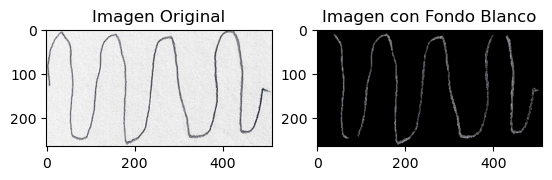

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convertir_fondo_a_blanco_grabcut(imagen):
    if imagen is None:
        print("Error: No se pudo leer la imagen.")
        return None

    # Crear una máscara inicial
    mask = np.zeros(imagen.shape[:2], np.uint8)

    # Establecer el área de interés (ROI) para la segmentación
    rect = (10, 10, imagen.shape[1]-10, imagen.shape[0]-10)

    # Inicializar el modelo de GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Aplicar GrabCut para segmentar el primer plano y el fondo
    cv2.grabCut(imagen, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modificar la máscara para asignar valores a las regiones de interés
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Crear una nueva imagen con fondo blanco
    nueva_imagen = np.ones_like(imagen) * 255
    nueva_imagen = cv2.bitwise_and(nueva_imagen, nueva_imagen, mask=mask2)

    # Agregar la imagen original con el nuevo fondo blanco
    nueva_imagen += cv2.bitwise_and(imagen, imagen, mask=mask2)

    return nueva_imagen

# Ejemplo de uso
imagen_original = cv2.imread("wave/training/healthy/V01HO02.png")
imagen_con_fondo_blanco = convertir_fondo_a_blanco_grabcut(imagen_original)

# Mostrar las imágenes
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imagen_con_fondo_blanco, cv2.COLOR_BGR2RGB))
plt.title("Imagen con Fondo Blanco")

plt.show()


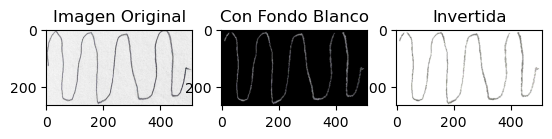

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convertir_fondo_a_blanco_grabcut(imagen):
    if imagen is None:
        print("Error: No se pudo leer la imagen.")
        return None

    # Crear una máscara inicial
    mask = np.zeros(imagen.shape[:2], np.uint8)

    # Establecer el área de interés (ROI) para la segmentación
    rect = (10, 10, imagen.shape[1]-10, imagen.shape[0]-10)

    # Inicializar el modelo de GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Aplicar GrabCut para segmentar el primer plano y el fondo
    cv2.grabCut(imagen, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modificar la máscara para asignar valores a las regiones de interés
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Crear una nueva imagen con fondo blanco
    imagen_con_fondo_blanco = np.ones_like(imagen) * 255
    imagen_con_fondo_blanco = cv2.bitwise_and(imagen_con_fondo_blanco, imagen_con_fondo_blanco, mask=mask2)

    # Agregar la imagen original con el nuevo fondo blanco
    imagen_con_fondo_blanco += cv2.bitwise_and(imagen, imagen, mask=mask2)

    return imagen_con_fondo_blanco

# Ejemplo de uso
imagen_original = cv2.imread("wave/training/healthy/V01HO02.png")
imagen_con_fondo_blanco = convertir_fondo_a_blanco_grabcut(imagen_original)

# Invertir colores (blanco a negro y negro a blanco)
imagen_invertida = cv2.bitwise_not(imagen_con_fondo_blanco)

# Mostrar las imágenes
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(imagen_con_fondo_blanco, cv2.COLOR_BGR2RGB))
plt.title("Con Fondo Blanco")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(imagen_invertida, cv2.COLOR_BGR2RGB))
plt.title("Invertida")

plt.show()


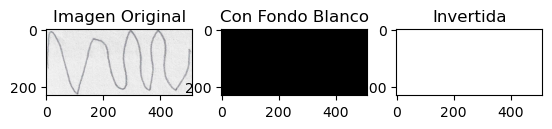

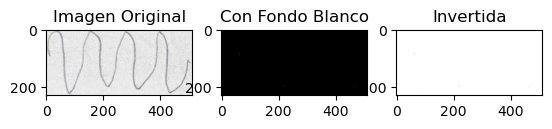

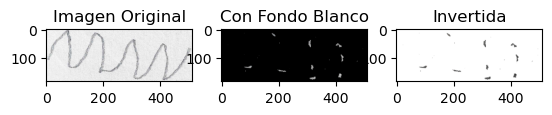

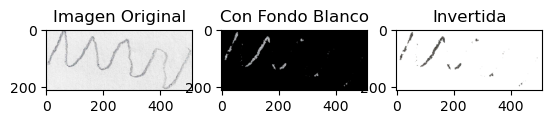

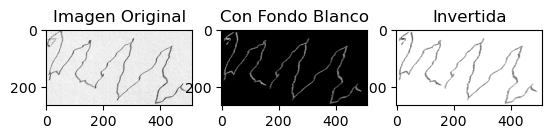

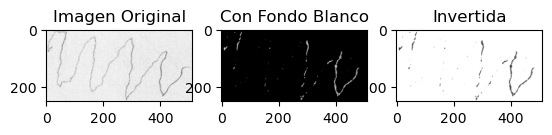

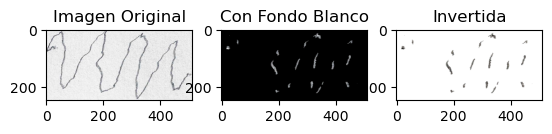

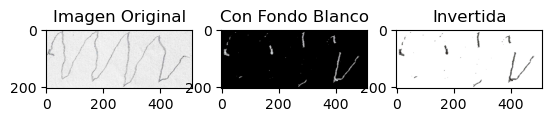

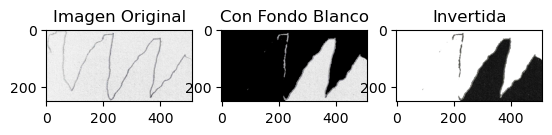

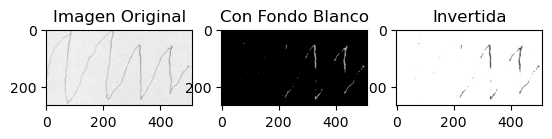

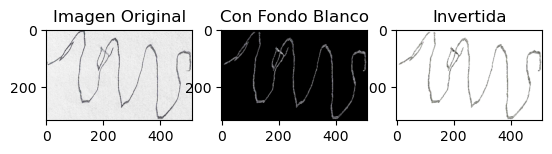

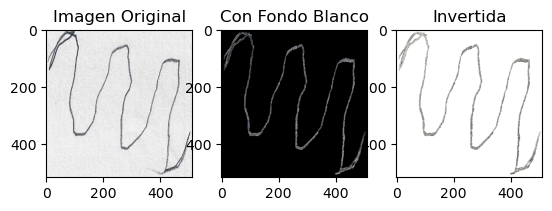

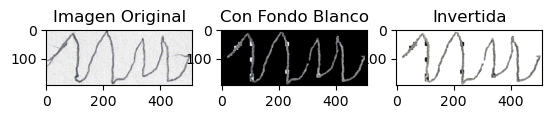

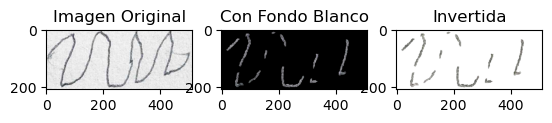

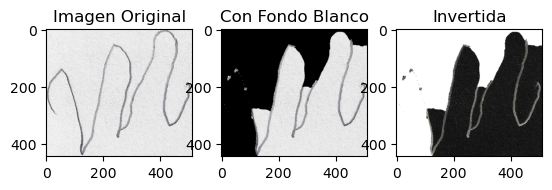

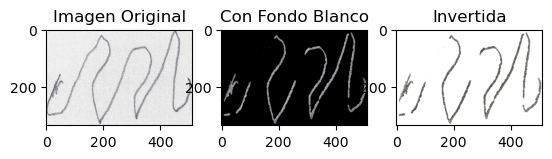

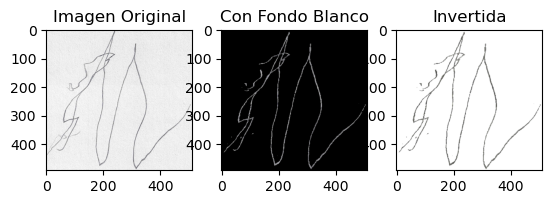

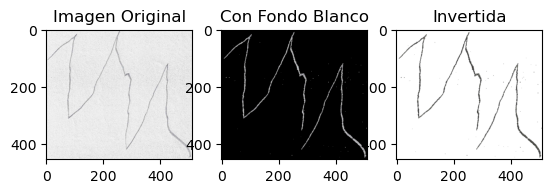

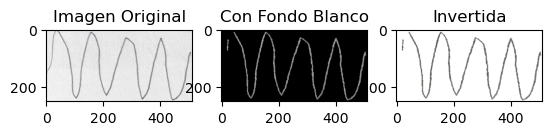

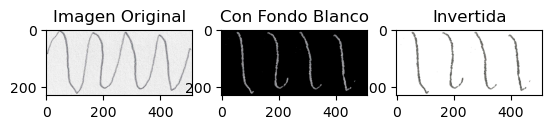

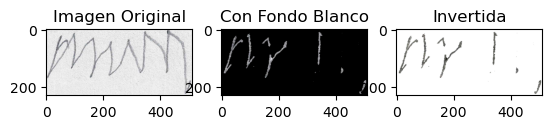

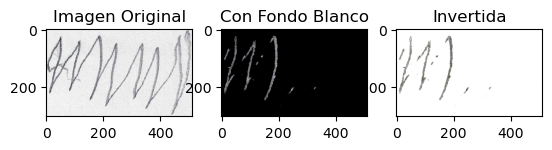

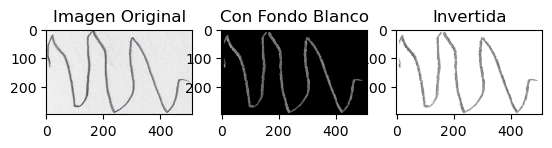

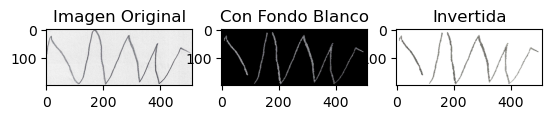

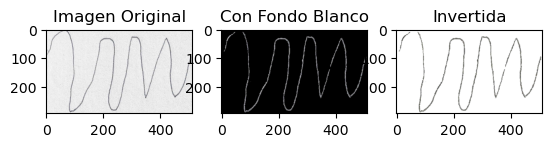

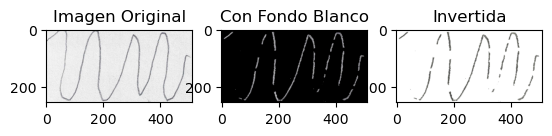

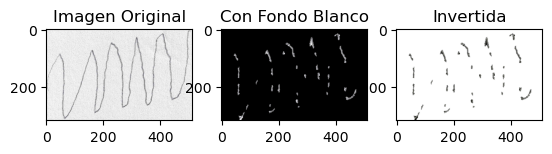

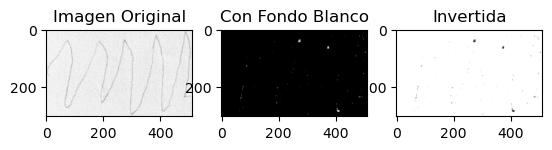

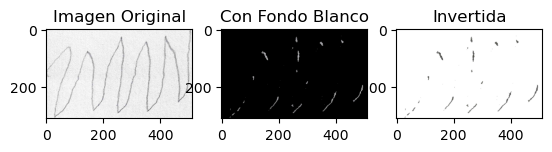

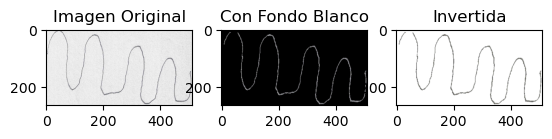

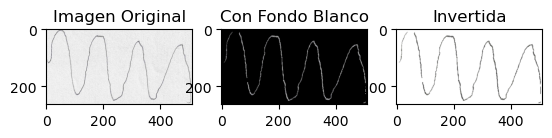

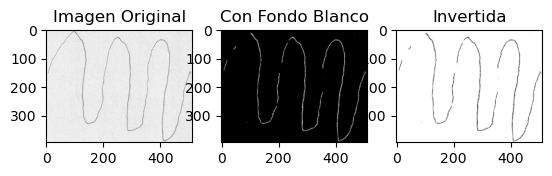

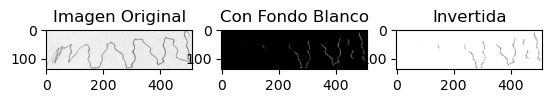

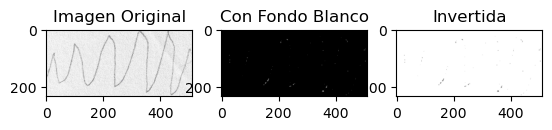

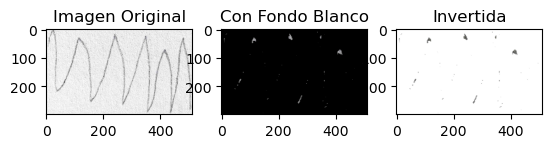

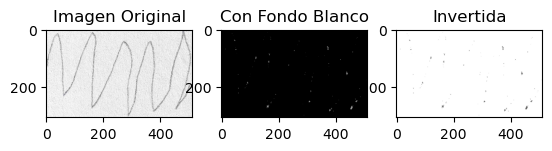

Aumentación de datos completada.


In [9]:
# buenoo
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directorio de las imágenes originales
directorio_original = "wave/training/parkinson/"
directorio_destino = "parkins_AD_Wave"
os.makedirs(directorio_destino, exist_ok=True)

# Número de ángulos para rotar la imagen
num_rotaciones = 10

def convertir_fondo_a_blanco_grabcut(imagen):
    if imagen is None:
        print("Error: No se pudo leer la imagen.")
        return None

    # Crear una máscara inicial
    mask = np.zeros(imagen.shape[:2], np.uint8)

    # Establecer el área de interés (ROI) para la segmentación
    rect = (10, 10, imagen.shape[1]-10, imagen.shape[0]-10)

    # Inicializar el modelo de GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Aplicar GrabCut para segmentar el primer plano y el fondo
    cv2.grabCut(imagen, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modificar la máscara para asignar valores a las regiones de interés
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Crear una nueva imagen con fondo blanco
    imagen_con_fondo_blanco = np.ones_like(imagen) * 255
    imagen_con_fondo_blanco = cv2.bitwise_and(imagen_con_fondo_blanco, imagen_con_fondo_blanco, mask=mask2)

    # Agregar la imagen original con el nuevo fondo blanco
    imagen_con_fondo_blanco += cv2.bitwise_and(imagen, imagen, mask=mask2)

    return imagen_con_fondo_blanco


# Iterar sobre las imágenes originales
for filename in os.listdir(directorio_original):
    ruta_original = os.path.join(directorio_original, filename)
    imagen_original = cv2.imread(ruta_original)
    imagen_con_fondo_blanco = convertir_fondo_a_blanco_grabcut(imagen_original)

    # Invertir colores (blanco a negro y negro a blanco)
    imagen_invertida = cv2.bitwise_not(imagen_con_fondo_blanco)

    # Mostrar las imágenes
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Original")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(imagen_con_fondo_blanco, cv2.COLOR_BGR2RGB))
    plt.title("Con Fondo Blanco")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(imagen_invertida, cv2.COLOR_BGR2RGB))
    plt.title("Invertida")

    plt.show()

print("Aumentación de datos completada.")


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directorio de las imágenes originales
directorio_original = "spiral/training/parkinson/"
directorio_destino = "parkins_AD"
os.makedirs(directorio_destino, exist_ok=True)

# Número de ángulos para rotar la imagen
num_rotaciones = 10

# Iterar sobre las imágenes originales
for filename in os.listdir(directorio_original):
    ruta_original = os.path.join(directorio_original, filename)
    imagen_original = cv2.imread(ruta_original)

    # Ángulos de rotación en grados
    angulos = np.linspace(0, 360, num_rotaciones)

    # Aplicar rotaciones y guardar imágenes aumentadas
    for i, angulo in enumerate(angulos):
        # Rotar la imagen
        imagen_rotada = imutils.rotate(imagen_original, angulo)

        # Nombre de la nueva imagen aumentada
        nombre_nueva_imagen = f"{filename[:-4]}_rotada_{i}.png"
        ruta_nueva_imagen = os.path.join(directorio_destino, nombre_nueva_imagen)

        # Guardar la imagen aumentada
        cv2.imwrite(ruta_nueva_imagen, imagen_rotada)

print("Aumentación de datos completada.")


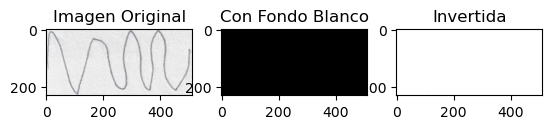

In [10]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def convertir_fondo_a_blanco_grabcut(imagen):
    if imagen is None:
        print("Error: No se pudo leer la imagen.")
        return None

    # Crear una máscara inicial
    mask = np.zeros(imagen.shape[:2], np.uint8)

    # Establecer el área de interés (ROI) para la segmentación
    rect = (10, 10, imagen.shape[1]-10, imagen.shape[0]-10)

    # Inicializar el modelo de GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Aplicar GrabCut para segmentar el primer plano y el fondo
    cv2.grabCut(imagen, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modificar la máscara para asignar valores a las regiones de interés
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Crear una nueva imagen con fondo blanco
    imagen_con_fondo_blanco = np.ones_like(imagen) * 255
    imagen_con_fondo_blanco = cv2.bitwise_and(imagen_con_fondo_blanco, imagen_con_fondo_blanco, mask=mask2)

    # Agregar la imagen original con el nuevo fondo blanco
    imagen_con_fondo_blanco += cv2.bitwise_and(imagen, imagen, mask=mask2)

    return imagen_con_fondo_blanco

# Directorio para almacenar las imágenes invertidas
output_directory = 'waves_blanco'
os.makedirs(output_directory, exist_ok=True)



# Ejemplo de uso
imagen_original = cv2.imread("wave/training/parkinson/V01PO02.png")
imagen_con_fondo_blanco = convertir_fondo_a_blanco_grabcut(imagen_original)

# Invertir colores (blanco a negro y negro a blanco)
imagen_invertida = cv2.bitwise_not(imagen_con_fondo_blanco)

# Guardar la imagen invertida en la carpeta especificada
nombre_archivo = "imagen_invertida.png"
ruta_guardado = os.path.join(output_directory, nombre_archivo)
cv2.imwrite(ruta_guardado, imagen_invertida)

# Mostrar las imágenes
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(imagen_con_fondo_blanco, cv2.COLOR_BGR2RGB))
plt.title("Con Fondo Blanco")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(imagen_invertida, cv2.COLOR_BGR2RGB))
plt.title("Invertida")

plt.show()


In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import imutils

# Directorio de las imágenes originales
directorio_original = "wave/training/parkinson/"
directorio_destino = "parkins_W_AD"
os.makedirs(directorio_destino, exist_ok=True)

# Número de ángulos para rotar la imagen
num_rotaciones = 10

# Iterar sobre las imágenes originales
for filename in os.listdir(directorio_original):
    ruta_original = os.path.join(directorio_original, filename)
    imagen_original = cv2.imread(ruta_original)

    # Ángulos de rotación en grados
    angulos = np.linspace(0, 360, num_rotaciones)

    # Aplicar rotaciones y guardar imágenes aumentadas
    for i, angulo in enumerate(angulos):
        # Rotar la imagen con fondo blanco
        imagen_rotada = imutils.rotate(imagen_original, angulo)
        imagen_rotada_con_fondo_blanco = convertir_fondo_a_blanco_grabcut(imagen_rotada)

        # Nombre de la nueva imagen aumentada
        nombre_nueva_imagen = f"{filename[:-4]}_rotada_{i}.png"
        ruta_nueva_imagen = os.path.join(directorio_destino, nombre_nueva_imagen)

        # Guardar la imagen aumentada
        cv2.imwrite(ruta_nueva_imagen, imagen_rotada_con_fondo_blanco)

print("Aumentación de datos completada.")


Aumentación de datos completada.
